# Tarea 7
*Evelyn Venegas Agustín*
422068635
Introducción a la ciencia de datos

In [2]:
#Primero cargamos el dataset

from sklearn.datasets import load_breast_cancer
dataset = load_breast_cancer()
X = dataset["data"]
y = dataset["target"]

#dividimos el dataset en 80%entrenamiento 20% test
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#y entrenamos el modelo con los parámetros por default para probar la precisión del mismo
modelo = DecisionTreeClassifier()
modelo.fit(X_train, y_train)

y_pred = modelo.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Precisión con parámetros default: ", accuracy)

#un 85% si bien no está nada mal, por la naturaleza del conjunto de datos, queremos que esta sea lo más alta posible, un 15% de diagnósticos
#equivocados en inadmisible



Precisión con parámetros default:  0.9210526315789473


In [3]:
#ajustamos los parámetros para maximizar el recall, con el objetivo de minimizar los falsos negativos

from sklearn.model_selection import GridSearchCV #gridsearch hará lo que hicimos en la práctica pasada, buscar el mejor set de parámetros

parametros = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'criterion': ['gini', 'entropy'],
    'class_weight': [None, 'balanced']
}

grid_search = GridSearchCV(DecisionTreeClassifier(), parametros, scoring='recall', cv=5)
grid_search.fit(X_train, y_train)

print("Mejores parámetros: ", grid_search.best_params_)
print("Mejor recall: ", grid_search.best_score_)

Mejores parámetros:  {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2}
Mejor recall:  0.9647869674185463


Una vez que tenemos esto hecho, calculamos la precisión

In [4]:
print("Precisión con parámetros ajustados: ", grid_search.score(X_test, y_test)) #mucho mejor, aunque aún está bajo para mi gusto

Precisión con parámetros ajustados:  0.9178082191780822


Ahora, haremos la validación cruzada con 5 folds, y veremos si la precisión mejora

In [5]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
precisiones=[]
tamaños=[]

for k, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    clf=DecisionTreeClassifier(**grid_search.best_params_)
    clf.fit(X_train, y_train)

    y_pred=clf.predict(X_test)
    precision=accuracy_score(y_test, y_pred)
    precisiones.append(precision)
    tamaños.append(len(y_test))

    print("Fold: ", k)
    print("Precisión: ", precision)
    print("Tamaño del test: ", len(y_test))
    print("---------------------------")

Fold:  0
Precisión:  0.9210526315789473
Tamaño del test:  114
---------------------------
Fold:  1
Precisión:  0.956140350877193
Tamaño del test:  114
---------------------------
Fold:  2
Precisión:  0.9385964912280702
Tamaño del test:  114
---------------------------
Fold:  3
Precisión:  0.956140350877193
Tamaño del test:  114
---------------------------
Fold:  4
Precisión:  0.9203539823008849
Tamaño del test:  113
---------------------------


In [6]:
#y calculamos la precisión promedio ponderada

import numpy as np

promedio_ponderada=np.average(precisiones, weights=tamaños)
print("Precisión promedio ponderada: ", promedio_ponderada)

Precisión promedio ponderada:  0.9384885764499121


En efecto, vemos que mejoró con respecto a solo ajustar los parámetros, aunque no mucho, es algo significativo. Ahora, importamos y aplicamos GradientBoosting

In [7]:
from sklearn.ensemble import GradientBoostingClassifier

gb_clf=GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=123)
gb_clf.fit(X_train, y_train)

y_pred=gb_clf.predict(X_test)
accuracy=accuracy_score(y_test, y_pred)
print("Precisión con GradientBoosting: ", accuracy)

Precisión con GradientBoosting:  0.9734513274336283


Vemos que mejora muchísimo, y no se alentó mucho el proceso, solo tardó 1 segundo en correr, aun con el parámetro default. Ahora probaremos diferentes valores para learning rate

In [8]:
rates=[0.01, 0.05, 0.2, 0.5, 1]

for r in rates:
  gb_clf_r=GradientBoostingClassifier(n_estimators=100, max_depth=3, learning_rate=r, random_state=123)
  gb_clf_r.fit(X_train, y_train)

  y_pred_r=gb_clf_r.predict(X_test)
  accuracy_r=accuracy_score(y_test, y_pred_r)
  print("Precisión con rate=",r," :", accuracy_r)
  print("----------------------")

Precisión con rate= 0.01  : 0.9557522123893806
----------------------
Precisión con rate= 0.05  : 0.9734513274336283
----------------------
Precisión con rate= 0.2  : 0.9734513274336283
----------------------
Precisión con rate= 0.5  : 0.9734513274336283
----------------------
Precisión con rate= 1  : 0.9823008849557522
----------------------


Vemos que, contrario a lo que parece, con un learning rate menor, el modelo alcanza una precisión mayor. ¿Es esto un indicio de que no siempre un learning rate pequeño lleva a una precison mejor? También es posible que con el numero de estimators, al poner 0.01, el modelo no haya alcanzado a clasificar bien los casos.

Ahora entrenamos al bosque aleatorio (aww que bonito nombre)

In [9]:
from sklearn.ensemble import RandomForestClassifier

rf_clf=RandomForestClassifier(n_estimators=100, random_state=123) #no le pongo max_depth pq en este caso, podemos costearnos el que el arbol crezca
rf_clf.fit(X_train, y_train)
y_pred_rf=rf_clf.predict(X_test)
accuracy_rf=accuracy_score(y_test, y_pred_rf)
print("Precisión con Random Forest: ", accuracy_rf)

Precisión con Random Forest:  0.9823008849557522


Vemos que la precisión mejor aún más. Un 98% me parece mucho mejor que lo que teníamos inicialmente. Ahora, generamos y comparamos la matriz de confusión para los tres casos anteriores

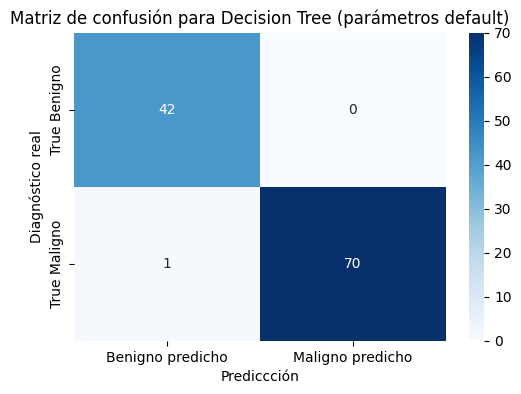

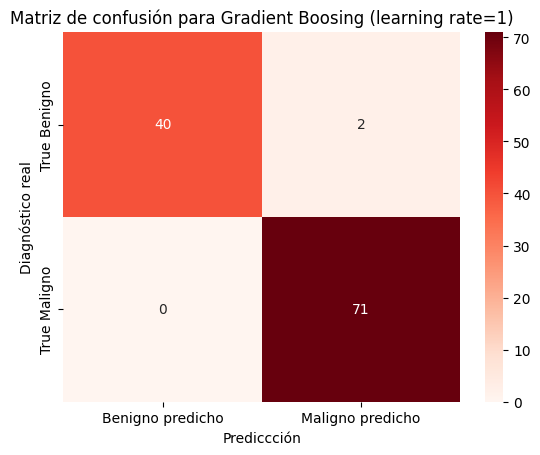

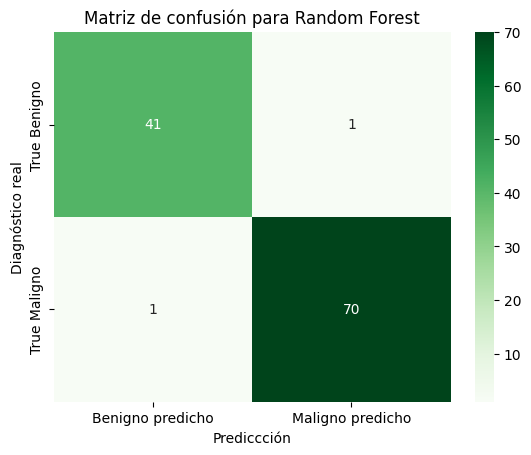

In [10]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

#DECISION TREE CLASSIFIER

#recalculamos los valores porque los reescribí :P
y_pred_default_dt = modelo.predict(X_test)
cm_default_dt = confusion_matrix(y_test, y_pred_default_dt)

plt.figure(figsize=(6, 4))
#veo que se pueden voltear los parámetros sin necesidad de definir la matriz a mano
sns.heatmap(cm_default_dt, annot=True, fmt='d', cmap='Blues', xticklabels=['Benigno predicho', 'Maligno predicho'], yticklabels=['True Benigno', 'True Maligno'])
plt.xlabel('Prediccción')
plt.ylabel('Diagnóstico real')
plt.title('Matriz de confusión para Decision Tree (parámetros default)')
plt.show()


#GRADIENT BOOSTING
#no lo vuelvo a calcular pq no lo reescribí
cm_gb = confusion_matrix(y_test, y_pred_r)

sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Reds', xticklabels=['Benigno predicho', 'Maligno predicho'], yticklabels=['True Benigno', 'True Maligno'])
plt.xlabel('Prediccción')
plt.ylabel('Diagnóstico real')
plt.title('Matriz de confusión para Gradient Boosing (learning rate=1)')
plt.show()


#RANDOM FOREST
cm_rf = confusion_matrix(y_test, y_pred_rf)

sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', xticklabels=['Benigno predicho', 'Maligno predicho'], yticklabels=['True Benigno', 'True Maligno'])
plt.xlabel('Prediccción')
plt.ylabel('Diagnóstico real')
plt.title('Matriz de confusión para Random Forest')
plt.show()

Veo que cometen errores muy concretos. Por un lado Decision Tree no da false positive, pero sí da un false negative. Como vimos en la clase donde analizamos este dataset, esto es peor que tener 1 false positive, pues a esta mujer no se le daría tratamiento a tiempo.

Por otra parte, Gradient Boosting no da false negatives, a cambio de 2 false positives. Y por último, random forest nos da 1 y 1. Estadísticamente es mejor Decision Tree, porque es el que comete menos errores en general. Pero desde un punto de vista médico, nos quedamos con Gradient Boosting, pues es el que da cero falsos negativos, por lo que en esta predicción, TODAS las mujeres recibirían tratamiento a tiempo, lo que es ideal.

Ahora veamos como varía la precisión cuando variamos n_estimators

Text(0.5, 1.0, 'Precisión vs n_estimators')

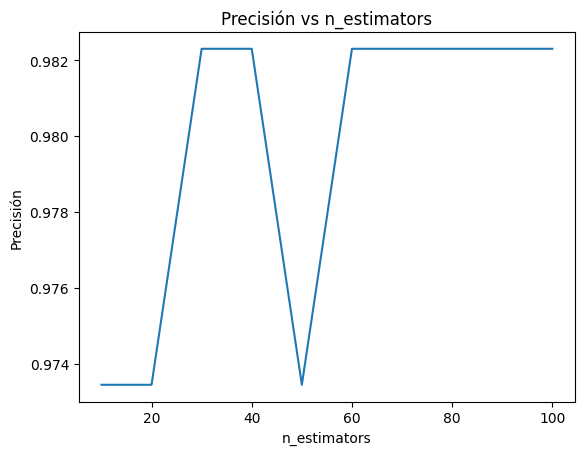

In [11]:
n_estimators=np.linspace(int(10),int(100),10).astype(int)
accuracies=[]

for n in n_estimators:
  rf_clf_n=RandomForestClassifier(n_estimators=n, random_state=123)
  rf_clf_n.fit(X_train, y_train)
  y_pred_rf_n=rf_clf_n.predict(X_test)
  accuracy_rf_n=accuracy_score(y_test, y_pred_rf_n)
  accuracies.append(accuracy_rf_n)

import matplotlib.pyplot as plt

plt.plot(n_estimators, accuracies)
plt.xlabel('n_estimators')
plt.ylabel('Precisión')
plt.title('Precisión vs n_estimators')

La gráfica lo hace ver más dramático de lo que debería, pero en realidad vemos una pequeña fluctuación en la precisión comparado con lo que teníamos al principio. Por lo que con 60 n_estimators tenemos la precisión máxima en nuestro modelo.

Ahora analicemos las importancias de cada característica

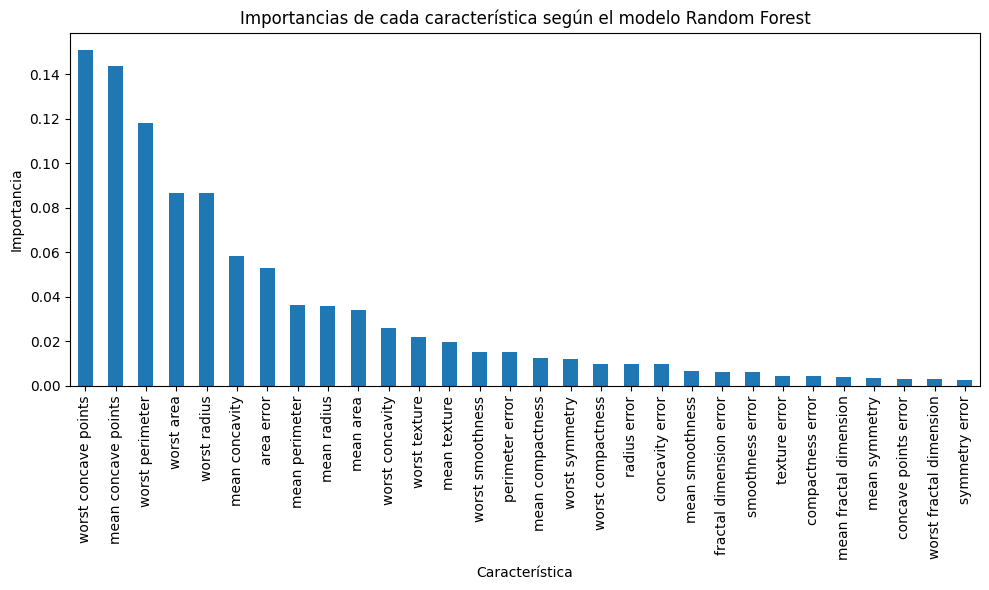

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#calculamos las importancias para random forest
importances = rf_clf.feature_importances_
feature_names = dataset.feature_names
feature_importances = pd.Series(importances, index=feature_names)

#las ordenamos en valores descendientes
feature_importances = feature_importances.sort_values(ascending=False)

#y graficamos
plt.figure(figsize=(10, 6))
feature_importances.plot(kind='bar')
plt.title('Importancias de cada característica según el modelo Random Forest')
plt.ylabel('Importancia')
plt.xlabel('Característica')
plt.tight_layout()
plt.show()

En efecto, recordando cuando hicimos el análisis manual de este dataset, las 10 primeras son las que tenían mayor correlación con el diagnóstico (target). Recuerdo que yo analicé mean concave points como característica más relacioanda. Lo veremos con una gráfica de dispersión

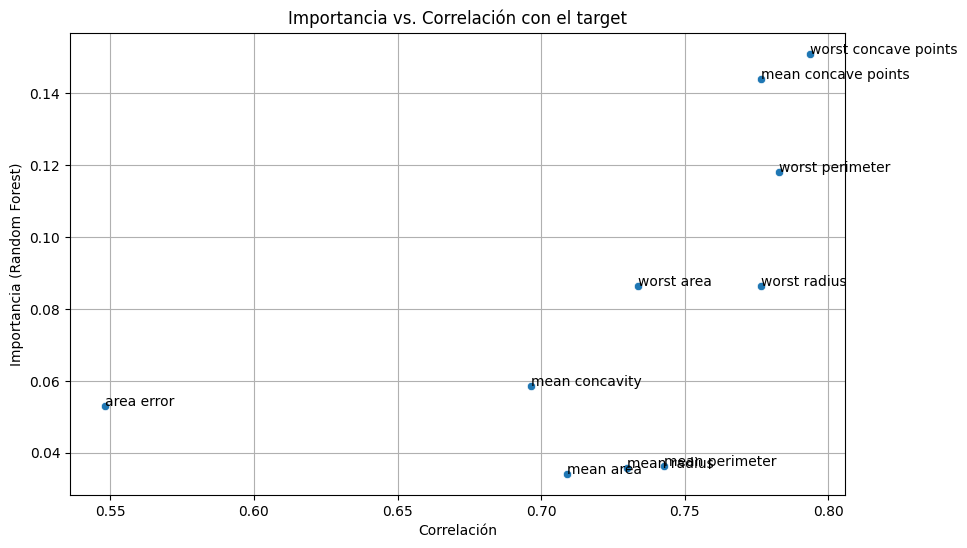

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

X_df = pd.DataFrame(X, columns=dataset.feature_names)

#calculamos las correlaciones
data_for_corr = pd.concat([X_df, pd.Series(y, name='target')], axis=1)
correlations = data_for_corr.corr()['target'].drop('target')

#veremos un plot de las importancias contra la correlación de cada característica
#metemos las correlaciones y las importancias en un dataframe (porque intenté hacerlo con arrays pero me arrojaba errores extraños)
importance_correlation_df = pd.DataFrame({
    'Importancia': feature_importances,
    'Correlación': correlations.abs() #sacamos val. absoluto
})

#y nos fijamos en las primeras 10
importance_correlation_df_top10 = importance_correlation_df.nlargest(10, 'Importancia')

plt.figure(figsize=(10, 6))
sns.scatterplot(data=importance_correlation_df_top10, x='Correlación', y='Importancia')
plt.title('Importancia vs. Correlación con el target')
plt.xlabel('Correlación')
plt.ylabel('Importancia (Random Forest)')
plt.grid(True)

#esto es para q cada punto tenga el nombre de la característica. Se ve un poco amontonado, pero las más importantes se alcanzan a ver bien
for i in range(importance_correlation_df_top10.shape[0]):
     plt.text(importance_correlation_df_top10['Correlación'].iloc[i], importance_correlation_df_top10['Importancia'].iloc[i], importance_correlation_df_top10.index[i])

plt.show()

In [23]:
import xgboost as xgb
import lightgbm as lgb
import time
from sklearn.metrics import accuracy_score

gb_clssf=GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=123)
xgb_clf=xgb.XGBClassifier(n_estimators=100, max_depth=3, eval_metric='logloss', random_state=123)
lgb_clf=lgb.LGBMClassifier(n_estimators=100, max_depth=3, random_state=123, verbose=-1) #verbose es para que no me muestre mucho output y los detalles de lo que hace

clasificadores = {
    "Gradient Boosting": gb_clssf,
    "XGBoost": xgb_clf,
    "LightGBM": lgb_clf
}

resultados = {}

#calculamos el tiempo que tarda cada clasificador vs su precision
for nom, clf in clasificadores.items():
    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()
    tiempo_entrenamiento = end-start

    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    resultados[nom] = {"Tiempo de entrenamiento (s)": tiempo_entrenamiento, "accuracy": accuracy}

print(resultados)

{'Gradient Boosting': {'Tiempo de entrenamiento (s)': 0.937908411026001, 'accuracy': 0.9734513274336283}, 'XGBoost': {'Tiempo de entrenamiento (s)': 0.05541706085205078, 'accuracy': 0.9734513274336283}, 'LightGBM': {'Tiempo de entrenamiento (s)': 0.054280757904052734, 'accuracy': 0.9734513274336283}}


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Vemos que Gradient Boosting tarda casi 1 segundo completo en ejecutarse, y pese a que entrega una muy buena precisión XGBoost y lightGBM tardan apenas 0.05 s. Eso es apenas el 5% del tiempo que le toma a GB. En este dataset particularmente no es muy notorio, pero en grandes datasets, una reducción del 95% del tiempo casi sin perder precisión es muy bueno! habría que probar en otros datasets para ver si esta reducción de tiempo se